### Данные из задачи

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import os.path
from os import path

beta = 3   
sigma = 1.5
P0 = 90

X0_stds = [500, 5, 5, 200, 5, 5]  # стандартное отклонение для вектора

u_list = [[0, 0], [3.5, 0], [0, 3.5], [-3.5, 0], [0, -3.5]]  # состояние марковской цепи
U = [np.array(x).reshape((2, 1)) for x in u_list]

# матрица переходов
P = {}
for i, key in enumerate(U):
  probs = np.ones(5)
  probs[i] = 16
  P[str(key)] = probs / 20

# дельта и альфа
delta_t = 0.5
alpha = 0.6

# матрицы
A_strike = np.array([
    [1, delta_t, delta_t**2 / 2],
    [0, 1      , delta_t       ],
    [0, 0      , alpha         ]
])
A = np.block([
    [A_strike         , np.zeros((3, 3))],
    [np.zeros((3, 3)), A_strike         ]
])

B_strike = np.array([delta_t**2 / 2, delta_t, 0]).reshape((3, 1))
B = np.block([
    [B_strike         , np.zeros((3, 1))],
    [np.zeros((3, 1)), B_strike         ],
])

C_strike = np.array([delta_t**2 / 2, delta_t, 1]).reshape((3, 1))
C = np.block([
    [C_strike         , np.zeros((3, 1))],
    [np.zeros((3, 1)), C_strike         ],
])

### Описание работы частицы

In [2]:
class Particle:
  def __init__(self, x=None, u=None):
    if x is None:
      X = [np.random.normal(0, np.sqrt(X0_stds[i])) for i in range(len(X0_stds))]
      self.X = np.array(X).reshape((6, 1))
    else: self.X = x
    if u is None:
      self.U = U[np.random.choice(len(U))]
    else: self.U = u

  @classmethod
  def fromParticle(self, p):
    X = np.copy(p.X)
    U = np.copy(p.U)
    return self(X, U)

  def move(self):
    A_comp = np.matmul(A, self.X)
    B_comp = np.matmul(B, self.U)
    C_comp = np.matmul(C, np.random.normal(0, 1, size=(2, 1)))

    self.X = A_comp + B_comp + C_comp
    self.U = U[np.random.choice(len(U), p=P[str(self.U)])]

  @property
  def coords(self):
    return (self.X[0, 0], self.X[3, 0])

### Чтение показаний станций

In [3]:
folder = "C:\\Users\\apexk\\simulation_modeling\\4\\"

flie_to_read = folder + r"RSSI-measurements.txt"
with open(flie_to_read) as f:
  ms = np.array([[float(x) for x in line.split()] for line in f])

flie_to_read = folder + r"stations.txt"
with open(flie_to_read) as f:
  st_coords = np.array([[float(x) for x in line.split()] for line in f])

logs = (ms-90-np.random.normal(0, sigma, size=ms.shape)) / (-10*beta)
distances = np.power(np.full(ms.shape, 10), logs)

### Подсчет весов и ресемплинг

In [4]:
# Фильтр частиц - много частиц - симуляция робота (случайной величины, которая скрыта)
# На каждом этапе симулируем его действия (куда он едет)

# обновление веса частиц
def reweigh(weights, step):
  for index, p in enumerate(particle_list):
    x, y = p.coords
    weight = 1
    dist_list = np.sqrt((st_coords[0]-x)**2 + (st_coords[1]-y)**2)
    for d, m in zip(dist_list, distances[:,step]):
      # d - показания, m - измерение частицы
      weight *= norm.pdf(d, m, 150)
    weights[index] = weight
  
  weights /= np.sum(weights)
  return weights

# нормализация веса частиц (чтобы сумма была равна 1)
def normalize():
  global weights
  weights /= np.sum(weights)

# респемлинг (удаление частиц, которые слишком отличаются от показаний)
def resample(weights, N):
  global particle_list
  maximum = np.max(weights)
  index = np.random.randint(0, N)
  new_particle_list = []
  resampling_beta = 0

  # алгоритм колеса resampling'а
  for _ in range(N):
    resampling_beta += np.random.uniform(0, 2*maximum)
    while resampling_beta > weights[index]:
      resampling_beta -= weights[index]
      index = (index + 1) % N
    p = Particle.fromParticle(particle_list[index])
    new_particle_list.append(p)
  particle_list = new_particle_list

  weights /= np.sum(weights)
  return weights

### Запуск эксперимента

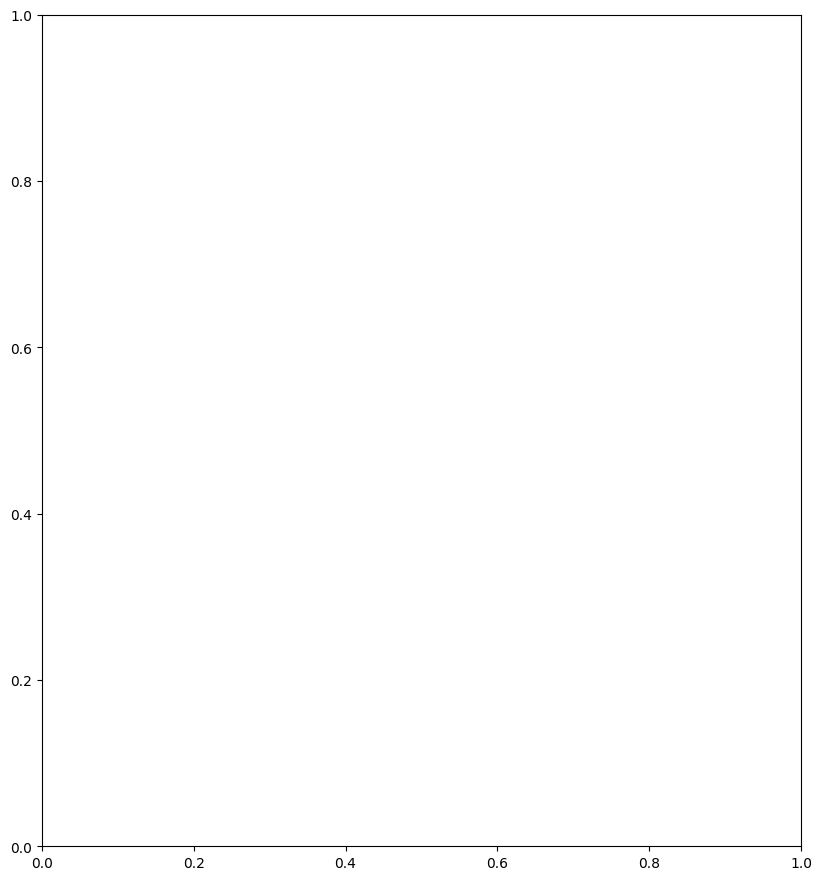

In [5]:
path_X = []
path_Y = []

N = 500
fig = plt.figure(figsize=(9.8, 10.8))
ax = fig.add_subplot(1, 1, 1)

def save_pic(name):
  X = []; Y = []
  for i, p in enumerate(particle_list):
    if i % 20 == 0:
      x, y = p.coords
      X.append(x)
      Y.append(y)

  est_X = np.average(
      [p.coords[0] for p in particle_list],
      weights=weights)
  est_Y = np.average(
      [p.coords[1] for p in particle_list],
      weights=weights)
  
  path_X.append(est_X)
  path_Y.append(est_Y)

  ax.scatter(X, Y, alpha=0.3)
  ax.plot(path_X, path_Y, color='green', linestyle='solid')
  ax.set_xlim(-2000, 5000)
  ax.set_ylim(-2000, 5000)
  fig.savefig(f'pics/{name}.png')
  ax.cla()

In [7]:
particle_list = [Particle() for _ in range(N)]
weights = np.full(N, 1/N)

if not path.exists('C:\\Users\\apexk\\simulation_modeling\\4\\pics'):
  os.mkdir('C:\\Users\\apexk\\simulation_modeling\\4\\pics')

save_pic('_start')

for i in range(1, len(distances[0])):
  for p in particle_list:
    p.move()
  weights = reweigh(weights, i)
  weights = resample(weights, N)
  save_pic("stage%04d" % i)

### Создание видео с траекторией

In [8]:
image_folder = 'C:\\Users\\apexk\\simulation_modeling\\4\\pics'
video_name = 'C:\\Users\\apexk\\simulation_modeling\\4\\videos\\video.mp4'

if not path.exists('C:\\Users\\apexk\\simulation_modeling\\4\\videos'):
  os.mkdir('C:\\Users\\apexk\\simulation_modeling\\4\\videos')

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images.sort()

frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(
    video_name,
    cv2.VideoWriter_fourcc('F','M','P','4'),
    30, (544, 600))

for image in images:
  image = cv2.imread(os.path.join(image_folder, image))
  image = cv2.resize(image, (544, 600))
  video.write(image)

cv2.destroyAllWindows()
video.release()